# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



В тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

Название команды на Kaggle: Хасан_Орен_634626348 [лидерборд с уже найденной командой](https://www.kaggle.com/competitions/journey-springfield/leaderboard?search=Хасан_Орен_634626348) Score: 0.97662

[профиль на kaggle](https://www.kaggle.com/renhas)

# Подготовка

## Опционально

Следующие три блока можно опустить, если ноутбук на kaggle с подключенным датасетом. Работоспособность **НЕ** проверялась, т.к. я работал через Kaggle с подключенным competition

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [2]:
# !unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [3]:
# !ls train

## Библиотечки

In [4]:
!pip install -q torchinfo

In [5]:
!pip install timm

In [121]:
#Python
import random
import os
from collections import Counter
from abc import ABC, abstractmethod, abstractproperty
from copy import deepcopy

import pandas as pd
import numpy as np

#Utility
from multiprocessing.pool import ThreadPool
from tqdm import tqdm_notebook
from tqdm.auto import tqdm
import warnings

#Files
import pickle
import pathlib
from pathlib import Path

#PyTorch
import torch
import torchvision.transforms.v2 as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
from torchinfo import summary

import timm

#Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#Graphics
import PIL
from PIL import Image
from skimage import io
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

## Полезности

In [7]:
#Фиксация сидов для воспроизводимости
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

In [119]:
class CFG:
    '''
    Конфигурационный класс, хранящий различные константы, флаги и прочее
    '''
    #Technical
    seed = 2024
    g_1 = torch.Generator()
    g_2 = torch.Generator()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    #Datasets and dataloaders
    batch_size = 256
    val_size = 0.25
    data_modes = ['train', 'val', 'test']
    img_size = 224
    
    #Paths
    dirs = {"train": Path('/kaggle/input/journey-springfield/train/simpsons_dataset'),
            "test": Path('/kaggle/input/journey-springfield/testset/')}
    save_path = "best_model_resnext101_32x8d.pt"
    
    #Model
    model_name='resnext101_32x8d'
    effnet = False
    best_score = 0
    num_epoch = 10
    
    #Optimizator and Scheduler
    opt_type = "AdamW"
    scheduler_type = "ExponentialLR"
    lr = 0.01
    scheduler_gamma = 0.9
    step_size = 5

In [9]:
def seed_worker(worker_id):
    '''Функция для воспроизводимости Dataloader`ов'''
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [10]:
seed_everything(CFG.seed)
CFG.g_1.manual_seed(CFG.seed)
CFG.g_2.manual_seed(CFG.seed)

In [11]:
if CFG.device == "cuda":
    print('CUDA is available! Training on GPU')
    !nvidia-smi
else:
    print('CUDA is not available. Training on CPU')

CUDA is available! Training on GPU
Sun Apr  7 13:03:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              27W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+--------------------------------

# Датасет

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Для загрузки изображений использованы торчевские ImageFolder'ы, с учётом этого немного переписаны все места использования датасетов и даталоадеров по сравнению с изначальным ноутбуком для дз.

Определим для начала аугментации - базовые для всех датасетов, включая тестовый, и дополнительные для тренировочных и валидационных данных. 

In [12]:
#Во второй версии transforms не рекомеднуется использовать ToTensor,
#вместо этого рекомендуется использовать такую связку, дающую аналогичный результат:
to_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])
base_transform = transforms.Compose([
    transforms.Resize((CFG.img_size,CFG.img_size)),
    to_tensor,
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    
])
train_val_transform = transforms.Compose([
    base_transform,
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5)
])
train_val_transform

Compose(
      Compose(
        Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
        Compose(
          ToImage()
          ToDtype(scale=True)
    )
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
  )
      RandomRotation(degrees=[-90.0, 90.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
      RandomHorizontalFlip(p=0.5)
      RandomVerticalFlip(p=0.5)
)

Базовый тренировочный датасет для визуализации данных без аугментаций

In [13]:
train_dataset_base = ImageFolder(CFG.dirs["train"], transform=base_transform)

In [14]:
train_dataset_all = ImageFolder(CFG.dirs["train"], transform=train_val_transform)

In [15]:
class_to_idx = train_dataset_base.class_to_idx
idx_to_class = {idx: label for label, idx in class_to_idx.items()}

Разделение данных на train и val. Разделяются по сути индексы изображений внутри датасета, после чего эти индексы используются для создания отдельных датасетов.

In [16]:
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset_all)),
    train_dataset_all.targets,
    stratify=train_dataset_all.targets,
    test_size=CFG.val_size,
    random_state=CFG.seed
)

In [17]:
train_dataset = Subset(train_dataset_all, train_indices)
val_dataset = Subset(train_dataset_all, val_indices)

## Визуализация

Практически все функции визуализации собраны здесь.

In [18]:
def show_results(values, names, figsize, ylabel, title=None):
    '''Отображение результатов обучения модели'''
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    for value, name in zip(values, names):
        plt.plot(value, label=name)
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel(ylabel)
    plt.show()

In [19]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [20]:
def show_samples(dataset, title=None):
    '''Отображение 9 рандомных картинок из датасета'''
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                           sharey=True, sharex=True)
    if title:
        fig.suptitle(title)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0,1000))
        im_val, label = dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),
                                 idx_to_class[label].split('_')))
        imshow(im_val.data.cpu(), \
              title=img_label, plt_ax=fig_x)
    plt.tight_layout()

In [21]:
def show_targets():
    '''Построение гистрограммы классов'''
    sns.set(palette='icefire')
    plt.figure(figsize=(20, 15))
    labels = train_dataset_base.targets
    labels = [idx_to_class[label] for label in labels]
    labels = sorted(labels, reverse=True)
    counts = dict(Counter(labels))
    classes = list(counts.keys())
    counts = list(counts.values())
    
    plt.barh(classes, counts)
    plt.title("Classes distribution")
    plt.show()

Давайте посмотрим на наших героев внутри датасета.

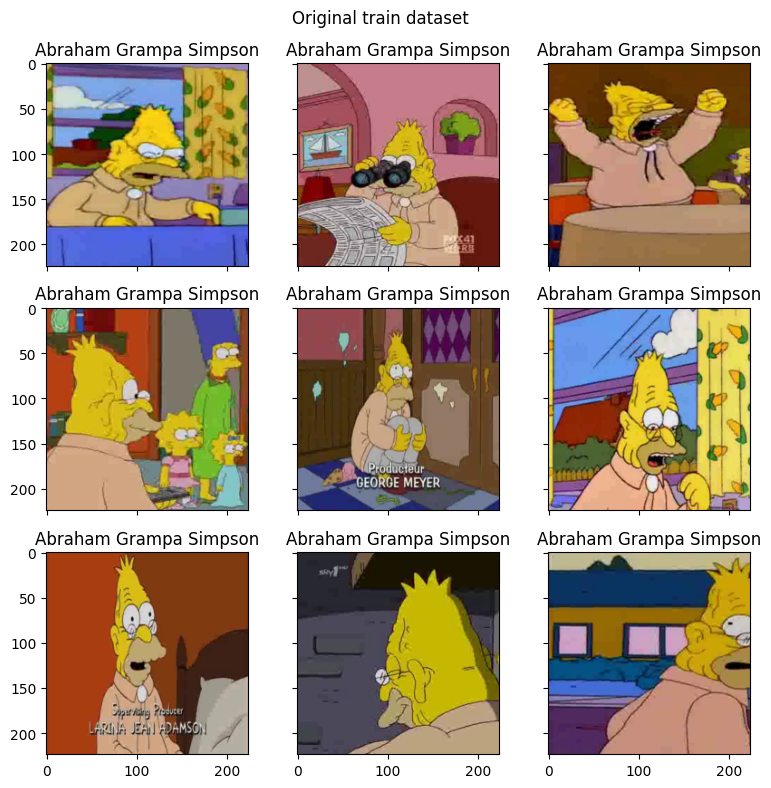

In [24]:
show_samples(train_dataset_base, "Original train dataset")

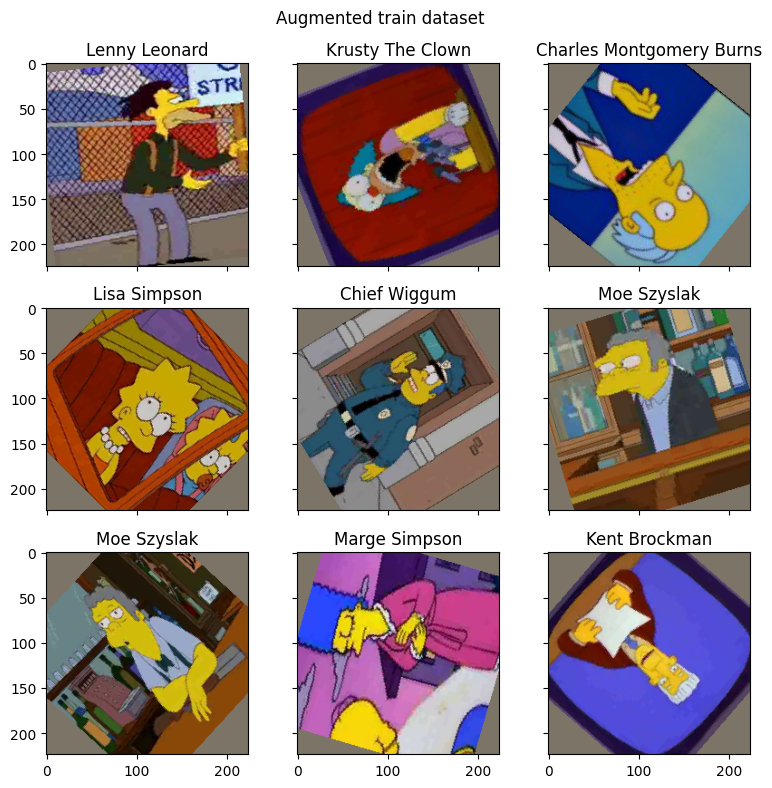

In [25]:
show_samples(train_dataset, "Augmented train dataset")

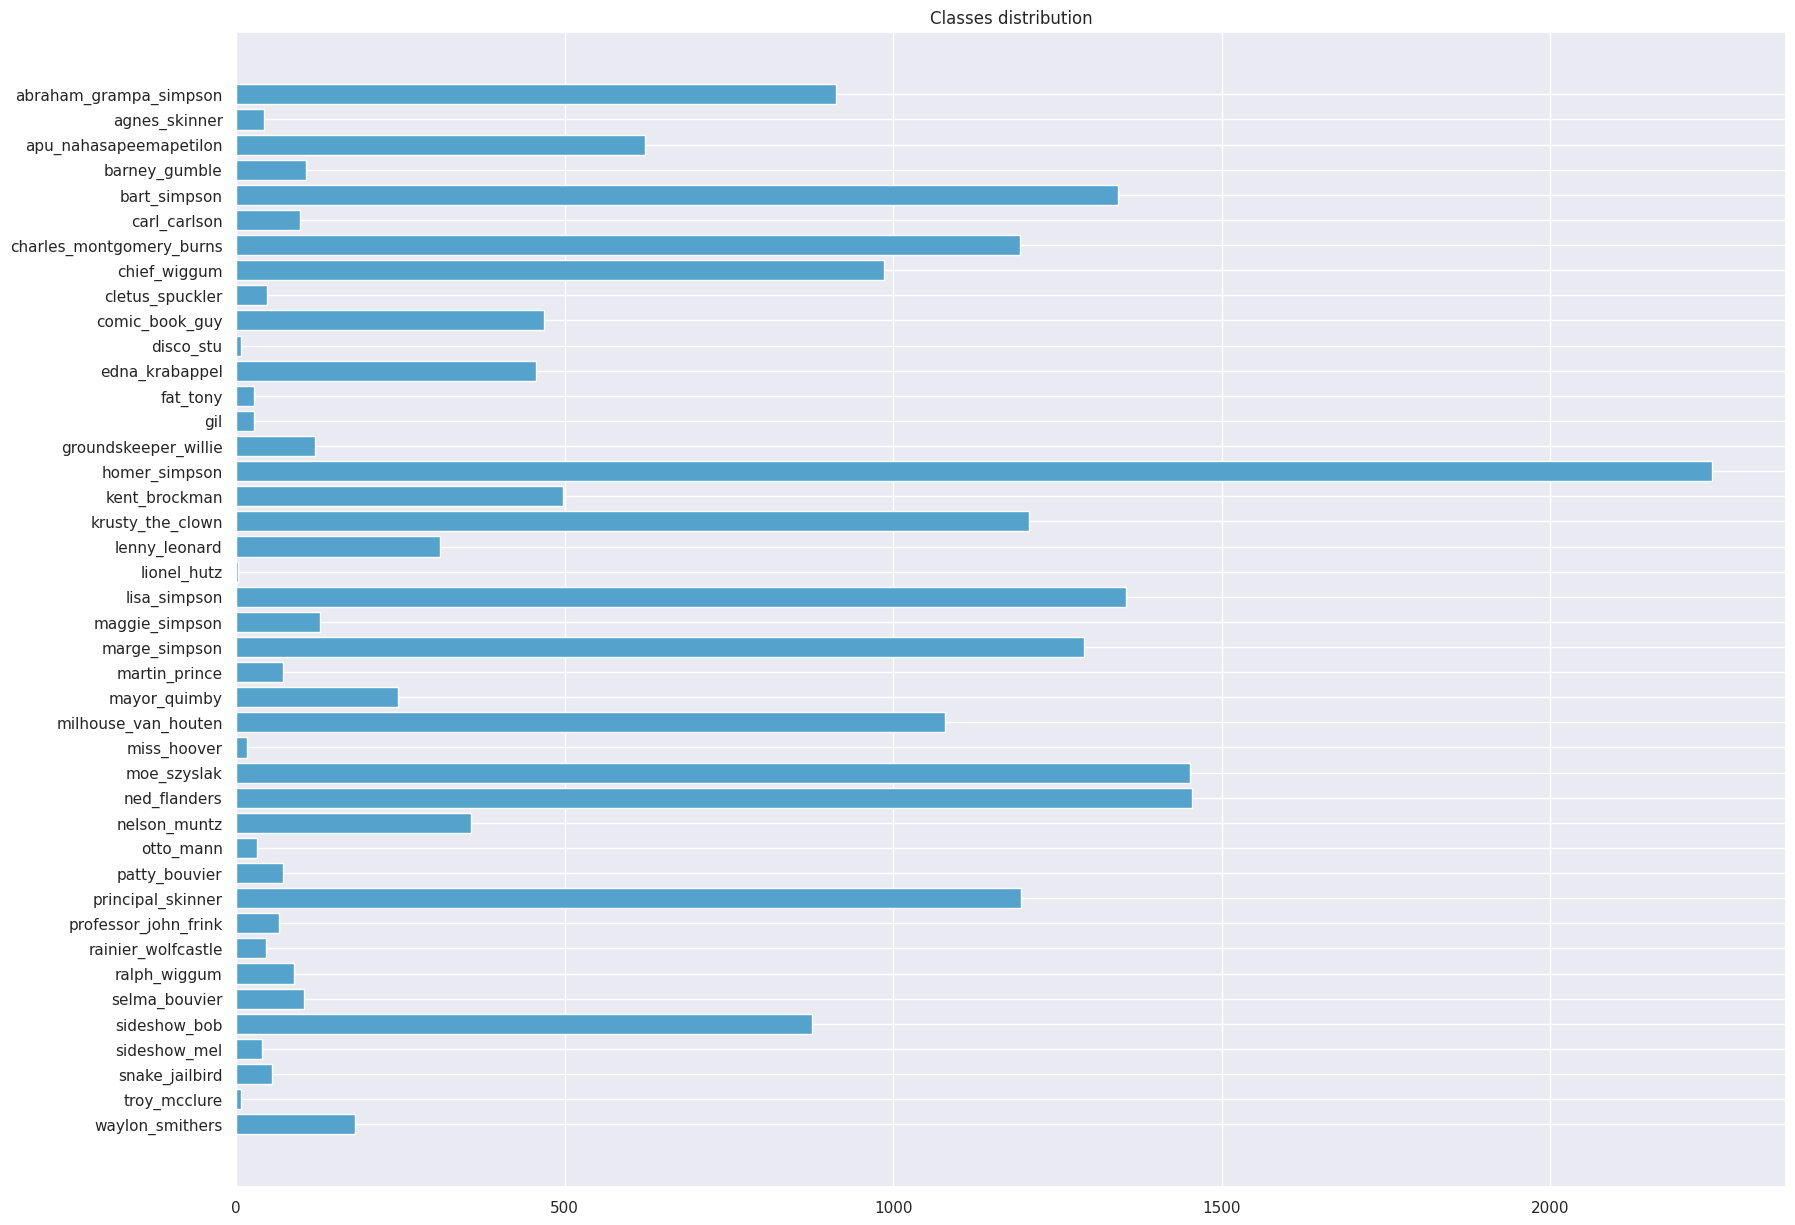

In [36]:
show_targets()

Видно, что у некоторых классов практически нет изображений во всём датасете, не говоря уже о двух разделённых (train и val). Однако данную проблему, скорее всего, сгладят аугментации, хоть и не сильно. 

# Обучение

Функции и классы, необходимые для обучения любой модели. 

Была идея инкапсулировать train и val эпохи в один класс, т.к. по сути они не сильно отличаются, однако в ноутбуке получается, что классы вместе со всякими вспомогательными штуками, типа стратегий, занимают слишком много места (в плане текста), поэтому было решено оставить две похожие функции, как обычно это и делается. 

In [22]:
class EpochResults:
    '''Инкапсуляция результатов для одной эпохи'''
    def __init__(self, loss = 0.0, count = 0, preds = [], labels = []):
        self.__loss = loss
        self.__count = count
        self.__preds = []
        self.__labels = []
        self.__preds.extend(preds)
        self.__labels.extend(labels)
    
    @property
    def loss(self):
        return self.__loss
    
    @property
    def count(self):
        return self.__count
    
    @property
    def preds(self):
        return deepcopy(self.__preds)
    
    @property
    def labels(self):
        return deepcopy(self.__labels)
    
    @property
    def results(self):
        loss = np.nan
        if self.__count != 0 :
            loss = self.__loss / self.__count
        score = f1_score(self.__labels, self.__preds, average='micro')
        return loss, score
    
    def __add__(self, other: "EpochResults"):
        return EpochResults(
            self.loss + other.loss,
            self.count + other.count,
            self.preds + other.preds,
            self.labels + other.labels)

In [23]:
def train_epoch(model, criterion, optimizer, train_dataloader, scheduler=None):
    model.train()
    results = EpochResults()

    for inputs, labels in tqdm(train_dataloader, desc="Train: "):
        inputs, labels = inputs.to(CFG.device), labels.to(CFG.device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)            
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        count = inputs.size(0)
        results += EpochResults(loss.item() * count,
                               count,
                               preds.detach().cpu().numpy(),
                               labels.detach().cpu().numpy())   
    if scheduler:
        scheduler.step()
    
    return results.results

In [24]:
def eval_epoch(model, criterion, eval_dataloader):
    model.eval()
    results = EpochResults()

    for inputs, labels in tqdm(eval_dataloader, desc="Val: "):
        inputs, labels = inputs.to(CFG.device), labels.to(CFG.device)
        
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        preds = torch.argmax(outputs, 1)
        count = inputs.size(0)
        results += EpochResults(loss.item() * count,
                               count,
                               preds.detach().cpu().numpy(),
                               labels.detach().cpu().numpy())   
    return results.results

In [25]:
def get_log_template():
    '''Формирует шаблон для лога'''
    log_template = "Train: loss = {t_loss:0.4f}, f1 = {t_f1:0.4f}\n"
    log_template += "Val: loss = {v_loss:0.4f}, f1 = {v_f1:0.4f}\n"
    log_template += "-"*50
    return log_template

In [26]:
def train(loaders, model, criterion, optimizer, scheduler=None, *,
         reset_score=False):
    '''Функция обучения модели'''
    history = []
    log_temp = get_log_template()
    if reset_score:
        CFG.best_score = 0
    for epoch in tqdm(range(CFG.num_epoch), desc="Epoch"):
        tqdm.write(f"Epoch: {epoch + 1}")
        train_loss, train_f1 = train_epoch(model, criterion, optimizer,
                                           loaders["train"], scheduler)
        val_loss, val_f1 = eval_epoch(model, criterion, loaders["val"])
        history.append((train_loss, train_f1, val_loss, val_f1))
        
        if CFG.best_score < val_f1:
            torch.save(model.state_dict(), CFG.save_path)
            CFG.best_score = val_f1
            
        tqdm.write(log_temp.format(t_loss=train_loss, t_f1=train_f1,
                                   v_loss=val_loss, v_f1=val_f1))
    return history

# Модель

Сеть будет иметь следующий вид:

* Некий feature extractor, на выбор. Обозначим выход с него n
* Классифицирующая голова:
    * Линейный слой (n, n//2) с батч-норм и ReLU
    * Линейный слой (n//2, n//2) с батч-норм и ReLU
    * Линейный слой (n//2, n//4) с дропаутом и ReLU
    * Выходной слой (n//4, 42)
    
По умолчанию, обучаем только голову.

In [106]:
class MyCNN(nn.Module):
    def __init__(self, model_name, n_classes, dropout_rate=0.5, *,
                 effnet=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)

        for param in self.model.parameters():
          param.requires_grad = False

        if effnet:
          fc_inputs = self.model.classifier.in_features
        else:
          fc_inputs = self.model.fc.in_features
        
        second_inputs = fc_inputs // 2
        third_inputs = second_inputs // 2
        fc1 = nn.Sequential(
            nn.Linear(fc_inputs, second_inputs),
            nn.BatchNorm1d(second_inputs),
            nn.ReLU(),
        )
        fc2 = nn.Sequential(
            nn.Linear(second_inputs, second_inputs),
            nn.BatchNorm1d(second_inputs),
            nn.ReLU(),
        )
        fc3 = nn.Sequential(
            nn.Linear(second_inputs, third_inputs),
            nn.Dropout(p=dropout_rate),
            nn.ReLU(),
        )
        head = nn.Sequential(fc1,
                             fc2,
                             fc3,
                             nn.Linear(third_inputs, n_classes))
        if effnet:
          self.model.classifier = head
        else:
          self.model.fc = head

    def forward(self, x):
        return self.model(x)

In [28]:
def opt_select(opt_name):
    '''Функция выбора оптимизатора'''
    match opt_name:
        case "Adam":
            return torch.optim.Adam
        case "AdamW":
            return torch.optim.AdamW
        case "Adadelta":
            return torch.optim.Adadelta

In [29]:
n_classes = len(class_to_idx.keys())
print(f"We will classify: {n_classes}")

We will classify: 42


Изначальная модель была обучена с помощью AdamW (lr = 0.01, amsgrad = False), ExponentialLR (gamma = 0.9) в течении 10 эпох. Показывала f1 score в районе 0.68.

Потом модель дообучалась с AdamW (lr = 0.01, amsgrad = True), ExponentialLR (gamma = 0.9) в течении 20 эпох. Предварительно было проделано 10 шагов scheduler'а, для получения lr из конца обучения первой модели. Финальная модель показала f1 score в районе 0.77 (0.79 на test).

Для третьей вариации были разморожены сверточные слои из Sequential: 2-8 (см. схему чуть ниже). Благодаря этому удалось достичь f1 score в районе 0.95 спустя 20 эпох. (0.97 на test). Обучалась она также, как и вторая вариация. 

[Сохраненные модели](https://www.kaggle.com/models/renhas/resnet_simpsons)

In [130]:
my_model = MyCNN(CFG.model_name, n_classes, effnet=CFG.effnet).to(CFG.device)
my_model.load_state_dict(torch.load("/kaggle/input/resnet_simpsons/pytorch/baseline/4/best_model_resnext101_32x8d_0.79.pt"))
my_model.eval()
pass

Разморозим несколько сверточных слоёв

In [131]:
for param in my_model.model.layer4.parameters():
    param.requires_grad = True

In [132]:
opt = opt_select(CFG.opt_type)(my_model.parameters(), CFG.lr, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=CFG.scheduler_gamma)
criterion = nn.CrossEntropyLoss()

Подгонка lr под тот, что был по окончании обучения базовой модели, т.к. требуются мелкие шаги. Можно было бы вручную задать более мелкий lr, но мы же не любим делать что-либо вручную, верно?)

In [151]:
for i in range(10):
    scheduler.step()

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [152]:
opt

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.003486784401000002
    maximize: False
    weight_decay: 0.01
)

Можно изменить depth на 4, если хочется посмотреть содержимое составных слоёв. Оставил 3, т.к. с 4 там очень длинный списочек получается. 

In [134]:
summary(model=my_model,
        input_size=(CFG.batch_size, 3, CFG.img_size, CFG.img_size), # входной батч
        col_names=["input_size", "output_size", "num_params", "trainable"], # что хотим посмотреть
        col_width=20,
        depth=3
)

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
MyCNN                                         [256, 3, 224, 224]   [256, 42]            --                   Partial
├─ResNet: 1-1                                 [256, 3, 224, 224]   [256, 42]            --                   Partial
│    └─Conv2d: 2-1                            [256, 3, 224, 224]   [256, 64, 112, 112]  (9,408)              False
│    └─BatchNorm2d: 2-2                       [256, 64, 112, 112]  [256, 64, 112, 112]  (128)                False
│    └─ReLU: 2-3                              [256, 64, 112, 112]  [256, 64, 112, 112]  --                   --
│    └─MaxPool2d: 2-4                         [256, 64, 112, 112]  [256, 64, 56, 56]    --                   --
│    └─Sequential: 2-5                        [256, 64, 56, 56]    [256, 256, 56, 56]   --                   False
│    │    └─Bottleneck: 3-1                   [256, 64, 56, 56]    [256, 256, 

Создадим loader'ы. Генераторы и worker_init_fn передаём в loader'ы для воспроизводимости. (Хотя не уверен, что оно прям в точности воспроизводится, но торч рекомендует делать так)

In [135]:
loaders_params = {
    "batch_size": CFG.batch_size,
    "worker_init_fn": seed_worker,
}
loaders = {
    "train": DataLoader(train_dataset, shuffle=True,
                        generator=CFG.g_1, **loaders_params),
    "val": DataLoader(val_dataset, shuffle=False,
                      generator=CFG.g_2, **loaders_params)
}

В качестве точки отсчёта возьмём f1 score загруженной модели

In [148]:
_, f1_base = eval_epoch(my_model, criterion, loaders["val"])
CFG.score = f1_base

Val:   0%|          | 0/21 [00:00<?, ?it/s]

In [149]:
CFG.score

0.7739778372181889

Запустим обучение сети.

In [153]:
history = train(loaders, my_model, criterion, opt, 
                scheduler=scheduler, reset_score=False)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 1.8224, f1 = 0.5595
Val: loss = 1.0625, f1 = 0.7339
--------------------------------------------------
Epoch: 2


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.7348, f1 = 0.8205
Val: loss = 0.6805, f1 = 0.8277
--------------------------------------------------
Epoch: 3


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.5120, f1 = 0.8735
Val: loss = 0.4719, f1 = 0.8754
--------------------------------------------------
Epoch: 4


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.4052, f1 = 0.8995
Val: loss = 0.4437, f1 = 0.8833
--------------------------------------------------
Epoch: 5


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.3230, f1 = 0.9180
Val: loss = 0.4119, f1 = 0.8964
--------------------------------------------------
Epoch: 6


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.2844, f1 = 0.9283
Val: loss = 0.3465, f1 = 0.9140
--------------------------------------------------
Epoch: 7


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.2443, f1 = 0.9369
Val: loss = 0.3035, f1 = 0.9249
--------------------------------------------------
Epoch: 8


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.2087, f1 = 0.9471
Val: loss = 0.3381, f1 = 0.9165
--------------------------------------------------
Epoch: 9


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.1797, f1 = 0.9546
Val: loss = 0.2954, f1 = 0.9263
--------------------------------------------------
Epoch: 10


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.1640, f1 = 0.9585
Val: loss = 0.2547, f1 = 0.9436
--------------------------------------------------


Попробуем продолжить обучение

In [164]:
history_2 = train(loaders, my_model, criterion, opt,
                  scheduler=scheduler, reset_score=False)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.1356, f1 = 0.9652
Val: loss = 0.2465, f1 = 0.9457
--------------------------------------------------
Epoch: 2


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.1155, f1 = 0.9704
Val: loss = 0.2435, f1 = 0.9461
--------------------------------------------------
Epoch: 3


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.1004, f1 = 0.9736
Val: loss = 0.2384, f1 = 0.9469
--------------------------------------------------
Epoch: 4


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.0952, f1 = 0.9750
Val: loss = 0.2258, f1 = 0.9538
--------------------------------------------------
Epoch: 5


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.0812, f1 = 0.9794
Val: loss = 0.2215, f1 = 0.9519
--------------------------------------------------
Epoch: 6


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.0796, f1 = 0.9796
Val: loss = 0.2225, f1 = 0.9526
--------------------------------------------------
Epoch: 7


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.0627, f1 = 0.9853
Val: loss = 0.2147, f1 = 0.9578
--------------------------------------------------
Epoch: 8


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.0606, f1 = 0.9847
Val: loss = 0.2067, f1 = 0.9568
--------------------------------------------------
Epoch: 9


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.0574, f1 = 0.9860
Val: loss = 0.2011, f1 = 0.9566
--------------------------------------------------
Epoch: 10


Train:   0%|          | 0/62 [00:00<?, ?it/s]

Val:   0%|          | 0/21 [00:00<?, ?it/s]

Train: loss = 0.0522, f1 = 0.9869
Val: loss = 0.2090, f1 = 0.9568
--------------------------------------------------


In [165]:
best_model = MyCNN(CFG.model_name, n_classes, effnet=CFG.effnet).to(CFG.device)
best_model.load_state_dict(torch.load(CFG.save_path))
best_model.eval()
pass

Построим кривые обучения

In [155]:
loss, f1, val_loss, val_f1 = zip(*history)

In [166]:
loss_2, f1_2, val_loss_2, val_f1_2 = zip(*history_2)

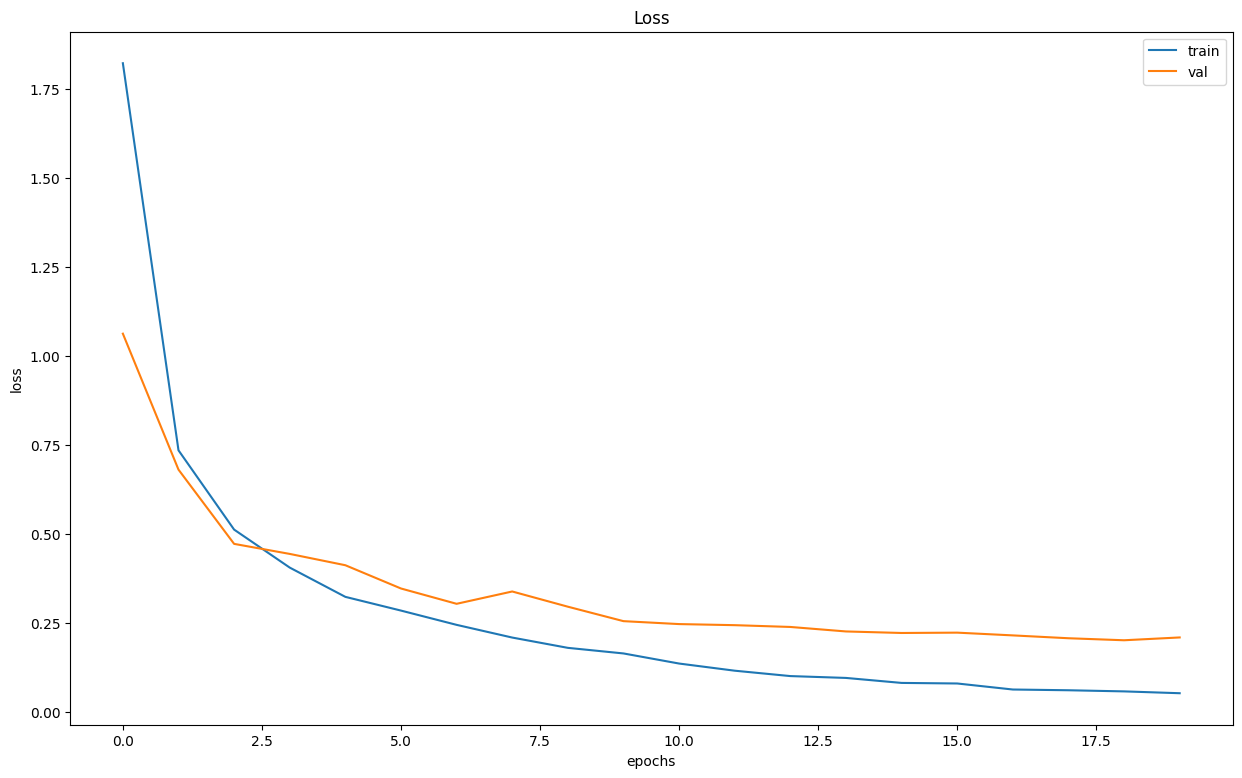

In [167]:
show_results([loss + loss_2, val_loss + val_loss_2], ["train", "val"],
            (15, 9), ylabel="loss", title="Loss")

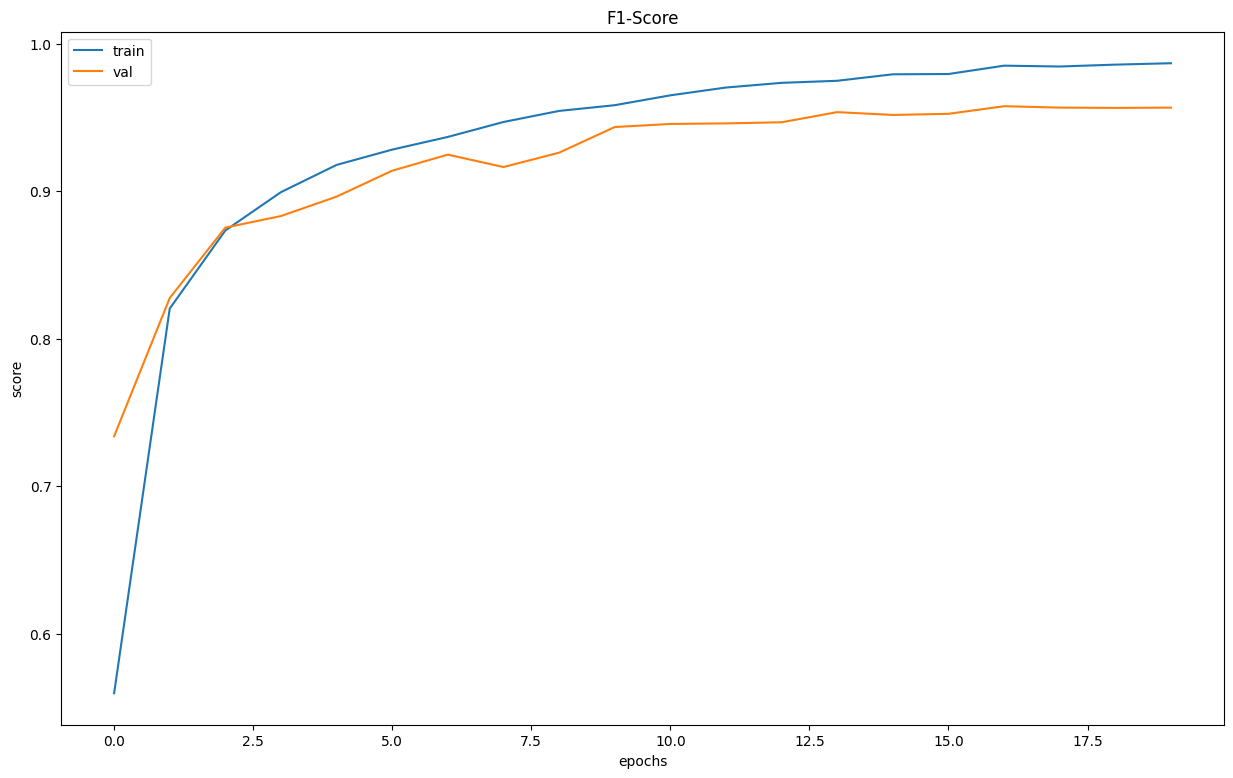

In [168]:
show_results([f1 + f1_2, val_f1 + val_f1_2], ["train", "val"],
            (15, 9), ylabel="score", title="F1-Score")

# Predict

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Теперь у нас есть обученная сеть и метод eval у нее, который позволяет перевести сеть в режим предсказания. 

Стоит помнить, что у нашей модели на последнем слое должен стоять softmax, который позволяет получить вектор вероятностей того, что объект относится к тому или иному классу.

In [158]:
def predict(model, test_loader):
    '''Предсказание на заданном датасете'''
    with torch.no_grad():
        model.eval()
        logits = []
        for inputs, _ in test_loader:
            inputs = inputs.to(CFG.device)
            outputs = model(inputs).cpu()
            logits.append(outputs)
        probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [159]:
def predict_one_sample(model, inputs):
    """Предсказание для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(CFG.device)
        model.eval()
        logit = model(inputs).cpu()
        probs = nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. 

*По хорошему, все функции визуализации собраны в разделе **Визуализация**, однако данная функция требует обученной модели и определения функций предсказания результатов, поэтому она тут.*

In [160]:
def visualise_preds(model):
    '''Визуализация картинок с подписями вероятности определённого класса'''
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0,1000))
        im_val, label = val_dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),
                                 idx_to_class[label].split('_')))

        imshow(im_val.data.cpu(), \
              title=img_label,plt_ax=fig_x)

        fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
        font0 = FontProperties()
        font = font0.copy()
        font.set_family("fantasy")
        prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
        predicted_proba = np.max(prob_pred)*100
        y_pred = np.argmax(prob_pred)

        predicted_label = idx_to_class[y_pred]
        predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
        predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

        fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                        verticalalignment='top',fontsize=8, color='black',fontweight='bold')
    plt.show()

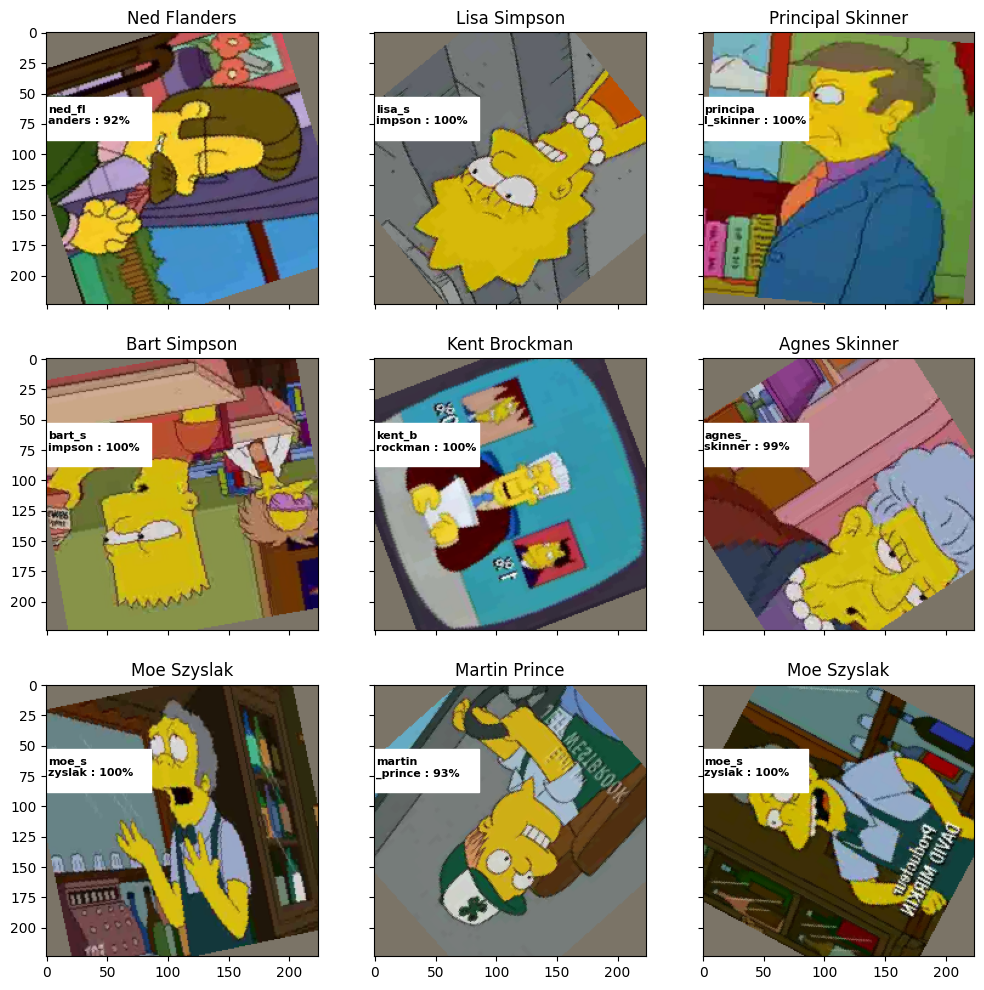

In [172]:
visualise_preds(best_model)

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [83]:
def get_submit_dt(model):
    '''Формирует DataFrame для сабмита на Kaggle'''
    test_dataset = ImageFolder(CFG.dirs["test"], transform=base_transform)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=CFG.batch_size)
    probs = predict(model, test_loader)

    preds = [idx_to_class[label] for label in np.argmax(probs, axis=1)]
    test_filenames = [os.path.basename(x[0]) for x in test_dataset.imgs]
    
    return pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [173]:
my_submit = get_submit_dt(best_model)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [174]:
my_submit.to_csv(f'my_predict_{CFG.model_name}_0.95.csv', index=False)

Финальная модель выдаёт public score 0.97662